Variables to determine car speed

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Importing Engine Data
with open('C:/Users/maxwe/Downloads/FSAE/2023-2024 Car/Repo/engine_data.pkl', 'rb') as file:
    engine_model = pickle.load(file)

vel_array = engine_model['vel_array']
a_array = engine_model['a_array']

# Importing Aero Model
with open('C:/Users/maxwe/Downloads/FSAE/2023-2024 Car/Repo/aero_model.pkl', 'rb') as file:
    aero_model = pickle.load(file)

aero_array = aero_model['aero_array'] # array to determine

# Importing Tire Data
with open('C:/Users/maxwe/Downloads/FSAE/2023-2024 Car/Repo/tire_model.pkl', 'rb') as file:
    tire_model = pickle.load(file)

f_y_F_lst = tire_model['f_y_F_lst']
f_y_R_lst = tire_model['f_y_R_lst']
# Array to determine coefficient of friction for lateral and longitudinal accel.
cmbr_coeff_fy_df = tire_model['cmbr_coeff_fy_df']
cmbr_coeff_fx_df = tire_model['cmbr_coeff_fx_df']

# Importing Car Model from car_model using PICKLE
with open('C:/Users/maxwe/Downloads/FSAE/2023-2024 Car/Repo/car_model.pkl', 'rb') as f:
    car_var = pickle.load(f)

# total weight of car (minus driver) (lbm)
w_car = car_var['W_T']
# weight bias, if less than 0.5, then the rear of the car will have more weight, if more than 0.5, then the front will have more weight
w_bias = car_var['W_bias']
# weight over front track
W_f = car_var['W_f']
# weight over rear track
W_r = car_var['W_r']
# weight over front left wheel
W_1 = car_var['W_1']
# weight over front right wheel
W_2 = car_var['W_2']
# weight over rear left wheel
W_3 = car_var['W_3']
# weight over rear right wheel
W_4 = car_var['W_4']
# length of wheelbase (in)
l = car_var['l']
# in, distance from CG to front track
a = car_var['a']
# in, distance from CG to rear track
b = car_var['b']
# vertical center of gravity (in)
h = car_var['h']
# in, CG height to roll axis
H = car_var['H']
# in, roll axis height, front and rear
z_rf = car_var['z_rf']
z_rr = car_var['z_rr']
# Track widths, front and rear (in)
t_f = car_var['t_f']
t_r = car_var['t_r']
 # lb/in, ride rates, front and rear
K_RF = car_var['K_RF']
K_RR = car_var['K_RR']
# lb*ft/deg, roll rates, front and rear
K_rollF = car_var['K_rollF']
K_rollR = car_var['K_rollR']
 #deg/in, camber rates for front and rear
CMB_RT_F = car_var['CMB_RT_F']
CMB_RT_R = car_var['CMB_RT_R']
# deg, static camber rates for front and rear
CMB_STC_F = car_var['CMB_STC_F']
CMB_STC_R = car_var['CMB_STC_R']
# setting pi as a number
pi = 3.14159
# tire grip limit (G's)
tire_a_G = car_var['tire_a']
# tire grip limit (in/s^2)
tire_a_ins = tire_a_G*32.2*12

Simple point-mass simulator: Straight Line

- This code simply shows how quickly a simple point mass vehicle can speed up and slow down a simple straight track when a constant accerleration is applied
- Assumed that the tires are the limiting factor, engine and gearing aren't considered
- boundary conditions require that the initial and final velocity be 0 mph
- This is a super basic model and won't accureately model how fast the car is

In [ ]:
# Run one: How quickly can the car start and stop along a straight line?

# straight line of 50 feet
track = 250
# Convertes track to inches
track = track*12

# discretizing track, dx = length of element (inches), n = number of elements
dx = 5
n = track/dx

# nodespace, nodes = list of x-value for each node in 1D
nodes = np.linspace(0,track,int(n+1))

# a_x is the acceleration limit, which in this model is the coefficient of friction for the tires

a_x = tire_a_ins

# Determine the speed if the car accelerated for the entire length of the traffic, starting from 0 mph at node 0
v1 = np.zeros(int(n+1))
for i in np.arange(n):
    v1[int(i+1)] = np.sqrt(v1[int(i)]**2 + 2*a_x*dx)

# Determine the speed if the car deaccelerated for the entire length of the traffic, ending at 0 mph at node n
v2 = np.zeros(int(n+1))
for i in np.arange(1,n+1):
    v2[int(-i-1)] = np.sqrt(v2[int(-i)]**2 + 2*a_x*dx)

# Determine which value of the two above lists is lowest. This list is the theoretical velocity at each node to satisfy the stated assumptions
v3 = np.zeros(int(n+1))
for i in np.arange(int(n)):
    if v1[i] < v2 [i]:
        v3[i] = (v1[int(i)])
    else:
        v3[i] = (v2[int(i)])

# Determining the total time it takes to travel the track by rewriting the equation v1 = v0 + a*t
t = 0
for i in np.arange(len(v3)-1):
    t += dx/np.average([v3[i+1],v3[i]])

print(f"total time to travel straight {round(t,5)} seconds")

plt.plot(nodes/12,v3)
plt.xlabel(f'straight section, {track/12} ft')
plt.ylabel('Velocity, in/s')
plt.show

Simple point-mass simulator: Oval Track

- This code simply shows how quickly a simple point mass vehicle can speed up and slow down a simple oval track, where one corner has a radius of 25 ft, and the other corner has a radius of 35 ft. The straights connecting the two sections are both 50 ft.
- Assumed that the tires are the limiting factor, engine and gearing aren't considered
- Constant friction circle of 2.2 G's
- boundary conditions require that the initial velocity be 0 mph
- This is a super basic model and won't accureately model how fast the car is!

In [ ]:
# Run one: How quickly can the car start and stop along a straight line?

# Track components

# straight's,  line of 50 feet
t = np.array([50*12, pi*35*12, 50*12, pi*25*12])
track = np.sum(t)

# discretizing track
n = 500
dx = track/n

# nodespace
nodes = np.linspace(0,track,int(n+1))

# Acceleration limited by grip of tires
a = tire_a_ins

# Determining maximum lateral acceleration for the two corners

# 35 ft corner
v_c1 = np.sqrt(a*35*12)
# 25 ft corner
v_c2 = np.sqrt(a*25*12)

# Determine the speed if the car accelerated for the entire length of the traffic, starting from 0 mph at node 0
v1 = np.zeros(int(n+1))
v1[int(np.ceil(t[0]/dx)):int(np.ceil((t[0]+t[1])/dx))] = v_c1
v1[int(np.ceil((t[0]+t[1]+t[2])/dx)):] = v_c2
for i in np.arange(n):
    if (np.sqrt(v1[int(i)]**2 + 2*a*dx) < v1[int(i+1)]) or (v1[int(i+1)] == 0.):
        v1[int(i+1)] = np.sqrt(v1[int(i)]**2 + 2*a*dx)

# Determine the speed if the car deaccelerated for the entire length of the traffic, ending at 0 mph at node n
v2 = np.zeros(int(n+1))
v2[int(np.ceil(t[0]/dx)):int(np.ceil((t[0]+t[1])/dx))] = v_c1
v2[int(np.ceil((t[0]+t[1]+t[2])/dx)):] = v_c2
for i in np.arange(1,n+1):
    if (np.sqrt(v2[int(-i)]**2 + 2*a*dx) < v2[int(-i-1)]) or (v2[int(-i-1)] == 0.):
        v2[int(-i-1)] = np.sqrt(v2[int(-i)]**2 + 2*a*dx)

# Determine which value of the two above lists is lowest. This list is the theoretical velocity at each node to satisfy the stated assumptions
v3 = np.zeros(int(n+1))
for i in np.arange(int(n+1)):
    if v1[i] < v2 [i]:
        v3[i] = (v1[int(i)])
    else:
        v3[i] = (v2[int(i)])

# Determining the total time it takes to travel the track by rewriting the equation v1 = v0 + a*t
t = 0
for i in np.arange(len(v3)-1):
    t += dx/np.average([v3[i+1],v3[i]])
print(f"total time to travel straight {round(t,5)} seconds")

# Plotting result
plt.plot(nodes,v3)
plt.xlabel('straight section, 50 ft')
plt.ylabel('Velocity, in/s')
plt.show
print(f"total track distance = {round(track/12, 2)} ft")

Simple point-mass simulator: Oval Track with Curved Straights

- This code simply shows how quickly a simple point mass vehicle can speed up and slow down a simple oval track, where one corner has a radius of 25 ft, and the other corner has a radius of 35 ft. The straights connecting the two sections are both 50 ft.
- Assumed that the tires are the limiting factor, engine and gearing aren't considered
- Constant friction circle of 2.2 G's
- boundary conditions require that the initial velocity be 0 mph
- This is a super basic model and won't accureately model how fast the car is!

In [ ]:
# Run one: How quickly can the car start and stop along a straight line?

# Track components

# Determining the shape of the track

# Each element in the t_rad list corresponds to the radius of that element (in)
t_rad = np.array([200*12, 35*12, 200*12, 25*12])
# Each element in the t_len list corresponds to the length of that element (rad)
t_len = np.array([(1/4), pi, (1/4), pi])
# Determines the length of each element (inches)
t_len_tot = np.multiply(t_rad,t_len)
# Determines total length of track
track = np.sum(t_len_tot)

# discretizing track, n = number of elements, dx = length of element (inches)
n = 500
dx = track/n

# nodespace
nds = np.linspace(0,track,int(n+1))

# Maximum acceleration determined by the grip limit of the tires
a = tire_a_ins

# Determining maximum lateral acceleration for every turn
t_vel = np.sqrt(a*t_rad)

# List showing radius at every node. Used to calculate maximum tangential acceleration
nd_rad = np.zeros(int(n+1))

# Each line sets the maximum velocity for each 
for i in np.arange(len(t_len_tot)):
    nd_rad[int(np.ceil(np.sum(t_len_tot[0:i])/dx)):int(np.ceil(np.sum(t_len_tot[0:i+1])/dx))] = t_vel[i]
t_rad[-1] = t_rad[-2]

# Determine the speed if the car accelerated for the entire length of the traffic, starting from 0 mph at node 0
v1 = np.zeros(int(n+1))

for i in np.arange(len(t_len_tot)):
    v1[int(np.ceil(np.sum(t_len_tot[0:i])/dx)):int(np.ceil(np.sum(t_len_tot[0:i+1])/dx))] = t_vel[i]
v1[0] = 0
v1[-1] = v1[-2]

a_x_lst_noeng = []

for i in np.arange(n):
    a_tan = np.sqrt(abs(a**2 - ((v1[i]**4)/(nd_rad[i]**2))))
    if (np.sqrt(v1[int(i)]**2 + 2*a_tan*dx) < v1[int(i+1)]) or (v1[int(i+1)] == 0.):
        v1[int(i+1)] = np.sqrt(v1[int(i)]**2 + 2*a_tan*dx)
    a_x_lst_noeng.append(a_tan/(32.17*12))

# Determine the speed if the car deaccelerated for the entire length of the traffic, ending at 0 mph at node n
v2 = np.zeros(int(n+1))

for i in np.arange(len(t_len_tot)):
    v2[int(np.ceil(np.sum(t_len_tot[0:i])/dx)):int(np.ceil(np.sum(t_len_tot[0:i+1])/dx))] = t_vel[i]
v2[-1] = v2[-2]

for i in np.arange(1,n+1):
    a_tan = np.sqrt(abs(a**2 - ((v2[-i]**4)/(nd_rad[-i]**2))))
    if (np.sqrt(v2[int(-i)]**2 + 2*a_tan*dx) < v2[int(-i-1)]) or (v2[int(-i-1)] == 0.):
        v2[int(-i-1)] = np.sqrt(v2[int(-i)]**2 + 2*a_tan*dx)


# Determine which value of the two above lists is lowest. This list is the theoretical velocity at each node to satisfy the stated assumptions
v4 = np.zeros(int(n+1))
for i in np.arange(int(n+1)):
    if v1[i] < v2 [i]:
        v4[i] = (v1[int(i)])
    else:
        v4[i] = (v2[int(i)])

# Determining the total time it takes to travel the track by rewriting the equation v1 = v0 + a*t
t = 0
for i in np.arange(len(v2)-1):
    t += dx/np.average([v4[i+1],v4[i]])
print(f"total time to travel straight {round(t,5)} seconds")

# Plotting result
plt.plot(nds,v4)
plt.xlabel('straight section, 50 ft')
plt.ylabel('Velocity, in/s')
plt.show
print(f"total track distance = {round(track/12, 2)} ft")

Simple point-mass simulator: Straight Line w/Engine Data

- This code simply shows how quickly a simple point mass vehicle can speed up and slow down a simple straight track when tire grip limits and engine power limits are applied
- Assumed that the tires, engine, and gearing are the limiting factor, aero effects not considered
- boundary conditions require that the initial and final velocity be 0 mph
- This is a super basic model and won't accureately model how fast the car is

In [ ]:
# Run one: How quickly can the car start and stop along a straight line?

# Length of straight track in ft
track = 250
# Convertes track to inches
track = track*12

# discretizing track
dx = 5
n = track/dx

# nodespace
nodes = np.linspace(0,track,int(n+1))

# Determine the speed if the car accelerated for the entire length of the track, starting from 0 mph at node 0
v1 = np.zeros(int(n+1))

a_x_lst_pm_strt = []

for i in np.arange(n):
    a_tan = a_array[int(round(v1[int(i)]/17.6))]
    v1[int(i+1)] = np.sqrt(v1[int(i)]**2 + 2*a_tan*dx)
    a_x_lst_pm_strt.append(a_tan/(32.17*12))

# Determine the speed if the car deaccelerated for the entire length of the track, ending at 0 mph at node n

v2 = np.zeros(int(n+1))
for i in np.arange(1,n+1):
    v2[int(-i-1)] = np.sqrt(v2[int(-i)]**2 + 2*tire_a_ins*dx)

# Determine which value of the two above lists is lowest. This list is the theoretical velocity at each node to satisfy the stated assumptions
v4 = np.zeros(int(n+1))
for i in np.arange(int(n)):
    if v1[i] < v2 [i]:
        v4[i] = (v1[int(i)])
    else:
        v4[i] = (v2[int(i)])

# Determining the total time it takes to travel the track by rewriting the equation v1 = v0 + a*t
t = 0
for i in np.arange(len(v4)-1):
    t += dx/np.average([v4[i+1],v4[i]])
t_accel = 0
for i in np.arange(len(v1)-1):
    t_accel += dx/np.average([v1[i+1],v1[i]])
    

print(f"total time to run a track of length {track/12} ft is {round(t,5)} seconds if accelerating and braking")
print(f"total time to run a track of length {track/12} ft is {t_accel:0.5f} seconds if only accelerating")
print(f"The maximum longitudinal acceleration is {max(a_x_lst_pm_strt)} G's")

plt.plot(nodes,v4/17.6)
plt.xlabel(f'straight section, {track/12} ft')
plt.ylabel('Velocity, in/s')
plt.show

Simple point-mass simulator: Oval Track, Curved Straights, Engine Data

- This code simply shows how quickly a simple point mass vehicle can speed up and slow down a simple oval track, where one corner has a radius of 25 ft, and the other corner has a radius of 35 ft. The straights connecting the two sections are both 50 ft.
- Assumed that the tires, engine, and gearing are the limiting factor, aero effects not considered
- Constant friction circle of 2.2 G's
- boundary conditions require that the initial velocity be 0 mph
- This is a super basic model and won't accureately model how fast the car is!

In [ ]:
# Run one: How quickly can the car start and stop along a straight line?

# Track components

# Determining the shape of the track

# Each element in the t_rad list corresponds to the radius of that element (in)
t_rad = np.array([200*12, 35*12, 200*12, 25*12])
# Each element in the t_len list corresponds to the length of that element (rad)
t_len = np.array([(1/4), pi, (1/4), pi])
t_len_tot = np.multiply(t_rad,t_len)
track = np.sum(t_len_tot)

# discretizing track
n = 500
dx = track/n

# nodespace
nds = np.linspace(0,track,int(n+1))

# Determining maximum lateral acceleration for every turn
t_vel = np.sqrt(tire_a_ins*t_rad)

# List showing radius at every node. Used to calculate maximum tangential acceleration
nd_rad = np.zeros(int(n+1))

nd_rad[0:int(np.ceil(t_len_tot[0]/dx))] = t_rad[0]
nd_rad[int(np.ceil(t_len_tot[0]/dx)):int(np.ceil(np.sum(t_len_tot[0:2])/dx))] = t_rad[1]
nd_rad[int(np.ceil(np.sum(t_len_tot[0:2])/dx)):int(np.ceil(np.sum(t_len_tot[0:3])/dx))] = t_rad[2]
nd_rad[int(np.ceil((np.sum(t_len_tot[0:3]))/dx)):] = t_rad[3]

# Determine the speed if the car accelerated for the entire length of the traffic, starting from 0 mph at node 0
v1_pm = np.zeros(int(n+1))

v1_pm[0:int(np.ceil(t_len_tot[0]/dx))] = t_vel[0]
v1_pm[int(np.ceil(t_len_tot[0]/dx)):int(np.ceil(np.sum(t_len_tot[0:2])/dx))] = t_vel[1]
v1_pm[int(np.ceil(np.sum(t_len_tot[0:2])/dx)):int(np.ceil(np.sum(t_len_tot[0:3])/dx))] = t_vel[2]
v1_pm[int(np.ceil((np.sum(t_len_tot[0:3]))/dx)):] = t_vel[3]
v1_pm[0] = 0

a_x_lst_pm = []
a_y_lst_pm = []
a_lst_pm = []

for i in np.arange(n):
    # Below section determines maximum longitudinal acceleration (a_tan) by selecting whichever is lower, engine accel. limit or tire grip limit as explained in word doc.
    a_tan_tire = np.sqrt(abs(tire_a_ins**2 - ((v1_pm[i]**4)/(nd_rad[i]**2))))
    a_tan_engne = a_array[int(round(v1_pm[int(i)]/17.6))]
    if a_tan_tire > a_tan_engne:
        a_tan = a_tan_engne
    else:
        a_tan = a_tan_tire
    if (np.sqrt(v1_pm[int(i)]**2 + 2*a_tan*dx) < v1_pm[int(i+1)]) or (v1_pm[int(i+1)] == 0.):
        v1_pm[int(i+1)] = np.sqrt(v1_pm[int(i)]**2 + 2*a_tan*dx)

    a_x_lst_pm.append(a_tan/(32.17*12))
    a_y_lst_pm.append((v1_pm[i]**2)/(nd_rad[i])/(32.17*12))
    a_lst_pm.append(np.sqrt((a_tan/(32.17*12))**2 + ((v1_pm[i]**2)/(nd_rad[i])/(32.17*12))**2))

print(f"The maximum londitudinal acceleration is {max(a_x_lst_pm)} G's\n\
The maximum lateral acceleration is {max(a_y_lst_pm)} G's\n\
The maximum acceleration is {max(a_lst_pm)} G's")

# Determine the speed if the car deaccelerated for the entire length of the traffic, ending at 0 mph at node n
v2 = np.zeros(int(n+1))
v2[0:int(np.ceil(t_len_tot[0]/dx))] = t_vel[0]
v2[int(np.ceil(t_len_tot[0]/dx)):int(np.ceil(np.sum(t_len_tot[0:2])/dx))] = t_vel[1]
v2[int(np.ceil(np.sum(t_len_tot[0:2])/dx)):int(np.ceil(np.sum(t_len_tot[0:3])/dx))] = t_vel[2]
v2[int(np.ceil((np.sum(t_len_tot[0:3]))/dx)):] = t_vel[3]

for i in np.arange(1,n+1):
    a_tan = np.sqrt(abs(tire_a_ins**2 - ((v2[-i]**4)/(nd_rad[-i]**2))))
    if (np.sqrt(v2[int(-i)]**2 + 2*a_tan*dx) < v2[int(-i-1)]) or (v2[int(-i-1)] == 0.):
        v2[int(-i-1)] = np.sqrt(v2[int(-i)]**2 + 2*a_tan*dx)


# Determine which value of the two above lists is lowest. This list is the theoretical velocity at each node to satisfy the stated assumptions
v5 = np.zeros(int(n+1))
for i in np.arange(int(n+1)):
    if v1_pm[i] < v2 [i]:
        v5[i] = (v1_pm[int(i)])
    else:
        v5[i] = (v2[int(i)])

# Determining the total time it takes to travel the track by rewriting the equation v1_pm = v0 + a*t
t1 = 0
for i in np.arange(len(v5)-1):
    t1 += dx/np.average([v5[i+1],v5[i]])
print(f"total time to travel straight {t1} seconds")

# Plotting result
plt.plot(nds,v5/17.6)
plt.xlabel('straight section, 50 ft')
plt.ylabel('Velocity, in/s')
plt.show
print(f"total track distance = {round(track/12, 2)} ft")

Simple Point Mass Simulator: Straight Line, w/Engine Data, w/Longitudinal Weight Transfer
- This code simply shows how quickly a simple point mass vehicle can speed up and slow down a simple straight track when tire grip limits and engine power limits are applied
- This model accounts for weight transfer, so the total time to travel the track should be more than the previous straight line model
- Assumed that the tires, engine, and gearing are the limiting factor, aero effects not considered
- boundary conditions require that the initial and final velocity be 0 mph

total time to run a track of length 250.0 ft is 43.93181 seconds if accelerating and braking
total time to run a track of length 250.0 ft is 4.54508 seconds if only accelerating
The maximum longitudinal acceleration is 0.8014890426434583 G's


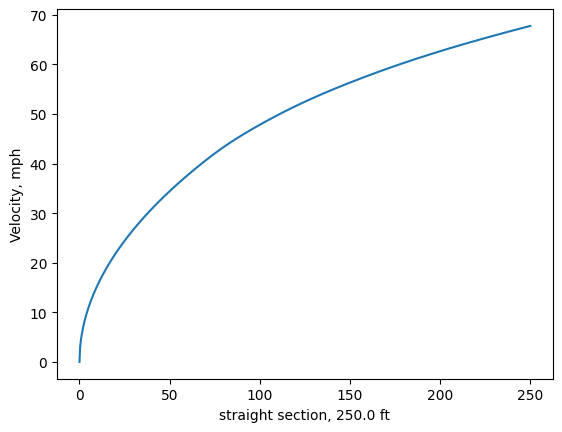

NameError: name 'a_x_lst_pm_strt' is not defined

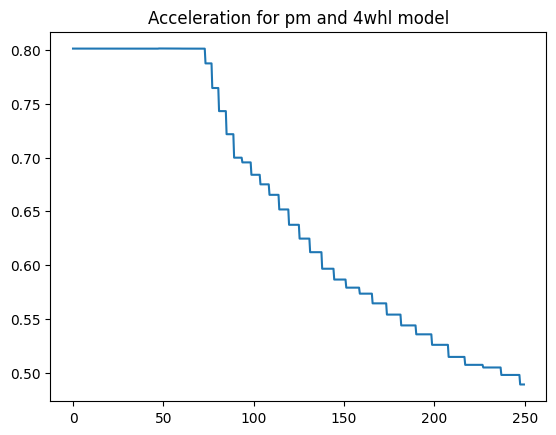

In [10]:
# Run one: How quickly can the car start and stop along a straight line?

# Length of straight track in ft
track = 250
# Convertes track to inches
track = track*12

# discretizing track
dx = 5
n = track/dx

# nodespace
nodes = np.linspace(0,track,int(n+1))

# Determine the speed if the car accelerated for the entire length of the track, starting from 0 mph at node 0
v1 = np.zeros(int(n+1))

a_x_lst_4whl_strt = []

for i in np.arange(int(n)):
    engine_a_ins = a_array[int(round(v1[i]/17.6))]
    engine_a_G = engine_a_ins/(12*32.17)
    a_r_G = engine_a_G # Initiate a_r_G (acceleration of the car in G's) by assuming that engine power is the limiting factor
    err = 1 # initiating error for the 'while' loop
    while err > 0.001:
        change_W_r = h/l*a_r_G*w_car # calculating the weight transfer to the rear wheels from engine power/traction limit 
        change_W_4 = change_W_r/2 # calculating weight transfer to one rear wheel
        y_disp = change_W_4/K_RR # calculating displacement of one rear wheel
        cmb = CMB_RT_R*y_disp + CMB_STC_R # calculating the camber seen by the wheel
        new_W_4 = W_4 + change_W_4 # Adding the weight transfer to the static weight for one rear tire
        F_r = 2*new_W_4*cmbr_coeff_fx_df[int(cmb/10),int(new_W_4)] # Multiplying the total weight by coefficient of friction to find acceleration of the entire car if limited by tire grip
        new_a_r_G = F_r/w_car # Calculating new longitudinal acceleration in G's if limited by tire grip limit
        if engine_a_G < new_a_r_G: # if the calculated traction limit acceleration (in G's) is less than than the engine power limite (in G's), acceleration is limited by tire grip limit so the loop will continue to iterate
            break
        err = abs((new_a_r_G-a_r_G)/new_a_r_G)
        a_r_G = new_a_r_G
  
    a_r_ins = a_r_G*12*32.17 # calculating a_r in in/s^2

    aero_f = aero_array[int(round(v1[i]/17.6))] # Adding Aero effects to Lapsim
    aero_a_G = aero_f/w_car
    aero_a_ins = aero_a_G*12*32.17
    a_r_ins -= aero_a_ins

    v1[i+1] = np.sqrt(v1[i]**2 + 2*a_r_ins*dx) # using newtonian equation to find velocity for next element
    a_x_lst_4whl_strt.append(a_r_G)


# Determine the speed if the car deaccelerated for the entire length of the track, ending at 0 mph at node n
v2 = np.zeros(int(n+1))
for i in np.arange(n-1,-1,-1):
    a_r_G = tire_a_G # Initiate a_r_G as the maximum tire braking force
    err = 1 # initiating error for the 'while' loop
    while err > 0.001:
        change_W = h/l*a_r_G*w_car # calculating the weight transfer to the rear wheels from engine power/traction limit 
        change_W = change_W/2 # calculating weight transfer to one wheel
        Delta_y_f = change_W/K_RF # calculating vertical displacement of one rear wheel
        Delta_y_r = change_W/K_RR # calculating displacement of one rear wheel
        cmb_f = CMB_RT_F*Delta_y_f + CMB_STC_F# calculating front wheel camber
        cmb_r = CMB_RT_R*Delta_y_r + CMB_STC_R # calculating rear wheel camber
        new_W_2 = W_2 - change_W # Adding the weight transfer to the static weight for one front tire
        new_W_4 = W_4 + change_W # Adding the weight transfer to the static weight for one rear tire
        F_f = 2*new_W_2*cmbr_coeff_fx_df[int(cmb_f/10),int(new_W_2)] # Multiplying the total weight by coefficient of friction to find braking force from rear track
        F_r = 2*new_W_4*cmbr_coeff_fx_df[int(cmb_r/10),int(new_W_4)] # Multiplying the total weight by coefficient of friction to find braking force from rear track
        F_tot = F_f + F_r # Finding total force acting on car by adding front and rear tracks
        new_a_r_G = F_tot/w_car # Calculating new longitudinal acceleration in G's if limited by tire grip limit
        err = abs((new_a_r_G-a_r_G)/new_a_r_G) 
        a_r_G = new_a_r_G
    
    a_r_ins = a_r_G*12*32.17 # calculating a_r in in/s^2

    # aero_f = aero_array[int(round(v2[int(i)]/17.6))] # Adding Aero effects to Lapsim
    # aero_a_G = aero_f/w_car
    # aero_a_ins = aero_a_G*12*32.17
    # a_r_ins += aero_a_ins

    v2[int(i)] = np.sqrt(v2[int(i)]**2 + 2*a_r_ins*dx) # using newtonian equation to find velocity for next element

# Determine which value of the two above lists is lowest. This list is the theoretical velocity at each node to satisfy the stated assumptions
v4 = np.zeros(int(n+1))
for i in np.arange(int(n)):
    if v1[i] < v2 [i]:
        v4[i] = (v1[int(i)])
    else:
        v4[i] = (v2[int(i)])

# Determining the total time it takes to travel the track by rewriting the equation v1 = v0 + a*t
t = 0
for i in np.arange(len(v4)-1):
    t += dx/np.average([v4[i+1],v4[i]])

t_accel = 0
for i in np.arange(len(v1)-1):
    t_accel += dx/np.average([v1[i+1],v1[i]])
    

print(f"total time to run a track of length {track/12} ft is {round(t,5)} seconds if accelerating and braking")
print(f"total time to run a track of length {track/12} ft is {t_accel:0.5f} seconds if only accelerating")
print(f"The maximum longitudinal acceleration is {max(a_x_lst_4whl_strt)} G's")

plt.plot(nodes/12,v1/17.6)
plt.xlabel(f'straight section, {track/12} ft')
plt.ylabel('Velocity, mph')
plt.show()

plt.title('Acceleration for pm and 4whl model')
plt.plot(nodes[:-1]/12, a_x_lst_4whl_strt, label='4whl')
plt.plot(nodes[:-1]/12, a_x_lst_pm_strt, label='pm')
plt.xlabel(f'straight section, {track/12} ft')
plt.ylabel('Velocity, mph')
plt.legend()
plt.show()


Simple point-mass simulator: Oval Track, w/Curved Straights, w/Engine Data, w/Longitudinal and Lateral Weight Transfer

- This code simply shows how quickly a simple point mass vehicle can speed up and slow down a simple oval track, where one corner has a radius of 25 ft, and the other corner has a radius of 35 ft. The straights connecting the two sections are both 50 ft.
- Assumed that the tires, engine, and gearing are the limiting factor, aero effects not considered
- boundary conditions require that the initial velocity be 0 mph
- This is won't accureately model how fast the car is without aero data!

In [ ]:
# 1) Calculating Maximum Lateral Acceleration

a_y_G = 1
err = 1 # initiating error for the 'while' loop    
while err > 0.0001:
    change_W_y_f = a_y_G*w_car/t_f*(H*K_rollF/(K_rollF+K_rollR)+b/l*z_rf) # calculating lateral weight transfer for front track
    change_W_y_r = a_y_G*w_car/t_r*(H*K_rollR/(K_rollF+K_rollR)+a/l*z_rr) # calculating lateral weight transfer for front track
    W_in_f = W_2 - change_W_y_f # calculating normal force acting on front inside tire
    W_out_f = W_2 + change_W_y_f # calculating normal force acting on front outside tire
    W_in_r = W_4 - change_W_y_r # calculating normal force acting on rear inside tire
    W_out_r = W_4 + change_W_y_r # calculating normal force acting on rear outside tire

    # With camber and normal force known, calculate maximum possible lateral and longitudinal forces for each wheel. Then,
    # create a friction ellipse for each wheel
    disp_in_f = (W_in_f - W_2)/K_RF # calculating vertical suspension displacement
    disp_out_f = (W_out_f - W_2)/K_RF
    disp_in_r = (W_in_r - W_2)/K_RR
    disp_out_r = (W_out_r - W_2)/K_RR

    cmb_in_f = CMB_RT_F*disp_in_f + CMB_STC_F + (180/np.pi)*np.arctan((-disp_in_f+disp_out_f)/t_f) # calculating camber values, accounting for roll of frame
    cmb_out_f = CMB_RT_F*disp_out_f + CMB_STC_F - (180/np.pi)*np.arctan((-disp_in_f+disp_out_f)/t_f)
    cmb_in_r = CMB_RT_R*disp_in_r + CMB_STC_R + (180/np.pi)*np.arctan((-disp_in_r+disp_out_r)/t_r)
    cmb_out_r = CMB_RT_R*disp_out_r + CMB_STC_R - (180/np.pi)*np.arctan((-disp_in_r+disp_out_r)/t_r)

    f_y_max_in_f = W_in_f*cmbr_coeff_fy_df[int(cmb_in_f/10),int(W_in_f)]  # calculating lateral coeff. friction/max lat. G's
    f_y_max_out_f = W_out_f*cmbr_coeff_fy_df[int(cmb_out_f/10),int(W_out_f)]
    f_y_max_in_r = W_in_r*cmbr_coeff_fy_df[int(cmb_in_r/10),int(W_in_r)]
    f_y_max_out_r = W_out_r*cmbr_coeff_fy_df[int(cmb_out_r/10),int(W_out_r)]

    # Add up all the max. potential lateral forces from each wheel, and divide by the weight of the car to find lateral acceleration in Gs
    f_y_max = f_y_max_in_f + f_y_max_out_f + f_y_max_in_r + f_y_max_out_r
    new_a_y_G = f_y_max/w_car

    err = abs((new_a_y_G-a_y_G)/new_a_y_G)
    a_y_G = new_a_y_G  

max_a_y_G = a_y_G
max_a_y_ins = max_a_y_G*32.17*12
W_in_f_max_y = W_in_f
W_out_f_max_y = W_out_f
W_in_r_max_y = W_in_r
W_out_r_max_y = W_out_r


print(f"Maximum lateral acceleration = {max_a_y_G} G\nLateral Force from Front Track = {f_y_max_in_f+f_y_max_out_f}\nLateral Force from Rear Track = {f_y_max_in_r+f_y_max_out_r}")
print(f"W_in_f = {W_in_f}, W_out_f = {W_out_f}, W_in_r = {W_in_r}, W_out_r = {W_out_r}")

# 2) Determining Track Characteristics

# Each element in the t_rad list corresponds to the radius of that element (in)
t_rad = np.array([200*12, 35*12, 200*12, 25*12])
# Each element in the t_len list corresponds to the length of that element (rad)
t_len = np.array([(1/4), pi, (1/4), pi])
t_len_tot = np.multiply(t_rad,t_len)
track = np.sum(t_len_tot)

# discretizing track
n = 500
dx = track/n

# nodespace
nds = np.linspace(0,track,int(n+1))

# Determining maximum lateral acceleration for every turn using equation a = v^2/r
t_vel = np.sqrt(max_a_y_ins*t_rad)

# List showing radius at every node. Used to calculate maximum tangential acceleration
nd_rad = np.zeros(int(n+1))

nd_rad[0:int(np.ceil(t_len_tot[0]/dx))] = t_rad[0]
nd_rad[int(np.ceil(t_len_tot[0]/dx)):int(np.ceil(np.sum(t_len_tot[0:2])/dx))] = t_rad[1]
nd_rad[int(np.ceil(np.sum(t_len_tot[0:2])/dx)):int(np.ceil(np.sum(t_len_tot[0:3])/dx))] = t_rad[2]
nd_rad[int(np.ceil((np.sum(t_len_tot[0:3]))/dx)):] = t_rad[3]

# 3) Calculating Velocities for the Lapsim

# Determine the speed if the car accelerated for the entire length of the traffic, starting from 0 mph at node 0

# Setting the maximum 
v1 = np.zeros(int(n+1))

v1[0:int(np.ceil(t_len_tot[0]/dx))] = t_vel[0]
v1[int(np.ceil(t_len_tot[0]/dx)):int(np.ceil(np.sum(t_len_tot[0:2])/dx))] = t_vel[1]
v1[int(np.ceil(np.sum(t_len_tot[0:2])/dx)):int(np.ceil(np.sum(t_len_tot[0:3])/dx))] = t_vel[2]
v1[int(np.ceil((np.sum(t_len_tot[0:3]))/dx)):] = t_vel[3]
v1[0] = 0

a1_x_lst_4whl = np.zeros(n)
a1_y_lst_4whl = np.zeros(n)
a1_lst_4whl = np.zeros(n)
W1_in_f_lst = np.full(n, W_in_f_max_y)
W1_out_f_lst = np.full(n, W_out_f_max_y)
W1_in_r_lst = np.full(n, W_in_r_max_y)
W1_out_r_lst = np.full(n, W_out_r_max_y)

for i in np.arange(n):
    engine_a_ins = a_array[int(round(v1[i]/17.6))]
    engine_a_G = engine_a_ins/(32.17*12)
    a_x_G = engine_a_G # Initiate a_r_G (acceleration of the car in G's) by assuming that engine power is the limiting factor
    a_y_ins = v1[i]**2 / nd_rad[i] # calculating radial acceleration of car
    a_y_G = a_y_ins/(32.17*12)
    err = 1 # initiating error for the 'while' loop    
    while err > 0.05:
    # Using either engine acceleration or tire grip limit and lateral acceleration, find normal force acting on each wheel
        change_W_x = h/l*a_x_G*w_car # calculating longidutinal weight transfer
        change_W_y_f = a_y_G*w_car/t_f*(H*K_rollF/(K_rollF+K_rollR)+b/l*z_rf) # calculating lateral weight transfer for front track
        change_W_y_r = a_y_G*w_car/t_r*(H*K_rollR/(K_rollF+K_rollR)+a/l*z_rr) # calculating lateral weight transfer for front track
        W_in_f = W_2 - change_W_y_f - change_W_x/2 # calculating normal force acting on front inside tire
        W_out_f = W_2 + change_W_y_f - change_W_x/2 # calculating normal force acting on front outside tire
        W_in_r = W_4 - change_W_y_r + change_W_x/2# calculating normal force acting on rear inside tire
        W_out_r = W_4 + change_W_y_r + change_W_x/2# calculating normal force acting on rear outside tire

        # With camber and normal force known, calculate maximum possible lateral and longitudinal forces for each wheel. Then,
        # create a friction ellipse for each wheel
        disp_in_f = (W_in_f - W_2)/K_RF # calculating vertical suspension displacement
        disp_out_f = (W_out_f - W_2)/K_RF
        disp_in_r = (W_in_r - W_2)/K_RR
        disp_out_r = (W_out_r - W_2)/K_RR

        cmb_in_f = CMB_RT_F*disp_in_f + CMB_STC_F + (180/np.pi)*np.arctan((-disp_in_f+disp_out_f)/t_f) # calculating camber values, accounting for roll of frame
        cmb_out_f = CMB_RT_F*disp_out_f + CMB_STC_F - (180/np.pi)*np.arctan((-disp_in_f+disp_out_f)/t_f)
        cmb_in_r = CMB_RT_R*disp_in_r + CMB_STC_R + (180/np.pi)*np.arctan((-disp_in_r+disp_out_r)/t_r)
        cmb_out_r = CMB_RT_R*disp_out_r + CMB_STC_R - (180/np.pi)*np.arctan((-disp_in_r+disp_out_r)/t_r)

        f_x_max_in_f = W_in_f*cmbr_coeff_fx_df[int(cmb_in_f/10),int(W_in_f)] # calculating lonitudinal coeff. friction/max long. G's
        f_x_max_out_f = W_out_f*cmbr_coeff_fx_df[int(cmb_out_f/10),int(W_out_f)]
        f_x_max_in_r = W_in_r*cmbr_coeff_fx_df[int(cmb_in_r/10),int(W_in_r)]
        f_x_max_out_r = W_out_r*cmbr_coeff_fx_df[int(cmb_out_r/10),int(W_out_r)]

        f_y_max_in_f = cmbr_coeff_fy_df[int(cmb_in_f/10),int(W_in_f)]  # calculating lateral coeff. friction/max lat. G's
        f_y_max_out_f = cmbr_coeff_fy_df[int(cmb_out_f/10),int(W_out_f)]
        f_y_max_in_r = cmbr_coeff_fy_df[int(cmb_in_r/10),int(W_in_r)]
        f_y_max_out_r = cmbr_coeff_fy_df[int(cmb_out_r/10),int(W_out_r)]

        # Add up all the max. potential lateral forces from each wheel, and divide the actual total lateral force by the max.
        # potential lateral force.
        f_y_max = f_y_max_in_f + f_y_max_out_f + f_y_max_in_r + f_y_max_out_r
        f_y_ratio = a_y_G / f_y_max

        # Multiply the max. lateral force at each wheel by this fraction, and use the friction ellipse to find the potential long.
        # force. The equation for an ellipse is (x^2/a^2) + (y^2/b^2) = 1, where a = f_x and b = f_y
        f_y_in_f = f_y_max_in_f*f_y_ratio # calculating actual f_y values for each wheel
        f_y_out_f = f_y_max_out_f*f_y_ratio
        f_y_in_r = f_y_max_in_r*f_y_ratio
        f_y_out_r = f_y_max_out_r*f_y_ratio

        if f_y_max_in_f!=0: # All 4 of these if statments make f_x = 0 if f_y_max = 0
            f_x_in_f = np.sqrt((1 - f_y_in_f**2 / f_y_max_in_f**2) * f_x_max_in_f**2)
        else:
            f_x_in_f = 0

        if f_y_max_out_f!=0:
            f_x_out_f = np.sqrt((1 - f_y_out_f**2 / f_y_max_out_f**2) * f_x_max_out_f**2)
        else:
            f_x_out_f = 0

        if f_y_max_in_r!=0:
            f_x_in_r = np.sqrt((1 - f_y_in_r**2 / f_y_max_in_r**2) * f_x_max_in_r**2)
        else:
            f_x_in_r = 0

        if f_y_max_out_r!=0:
            f_x_out_r = np.sqrt((1 - f_y_out_r**2 / f_y_max_out_r**2) * f_x_max_out_r**2)
        else:
            f_x_out_r = 0

        f_x = f_x_in_f + f_x_out_f + f_x_in_r + f_x_out_r # calculates longitudinal force acting on car

        new_a_x_G = f_x/w_car
        if engine_a_G < new_a_x_G: # if the calculated traction limit acceleration (in G's) is less than than the engine power limite (in G's), acceleration is limited by tire grip limit so the loop will continue to iterate
            break
        err = abs((new_a_x_G-a_x_G)/new_a_x_G)
        a_x_G = new_a_x_G

    #print(f"front inside = {W_in_f} lbs\nfront outside = {W_out_f} lbs\nrear inside = {W_in_r} lbs\nrear outside = {W_out_r} lbs\nlateral accel. = {a_y_G}\ndistance = {nds[i]/12} ft\n\n")

    a_x_ins = a_x_G*32.17*12

    if (np.sqrt(v1[int(i)]**2 + 2*a_x_ins*dx) < v1[int(i+1)]) or (v1[int(i+1)] == 0.):
        v1[int(i+1)] = np.sqrt(v1[int(i)]**2 + 2*a_x_ins*dx)
        a1_x_lst_4whl[i] = a_x_G
        W1_in_f_lst[i] = W_in_f
        W1_out_f_lst[i] = W_out_f
        W1_in_r_lst[i] = W_in_r
        W1_out_r_lst[i] = W_out_r
    a1_y_lst_4whl[i] = a_y_G
    a1_lst_4whl[i] = np.sqrt(a1_x_lst_4whl[i]**2 + a1_y_lst_4whl[i]**2)
    


    if W_in_f < 0 and W_in_r < 0: # Making sure that there are no negative normal forces (ie. the car is flipping)
        raise SystemExit("Car is flipping!")
        exit()


# print(f"The maximum Longidutinal Acceleration is {max(a1_x_lst_4whl)} G's\n\
# The maximum Lateral Acceleration is {max(a1_y_lst_4whl)} G's\n\
# The maximum acceleration is {max(a1_lst_4whl)} G's")

# Determine the speed if the car deaccelerated for the entire length of the traffic, ending at 0 mph at node n
v2 = np.zeros(int(n+1))
v2[0:int(np.ceil(t_len_tot[0]/dx))] = t_vel[0]
v2[int(np.ceil(t_len_tot[0]/dx)):int(np.ceil(np.sum(t_len_tot[0:2])/dx))] = t_vel[1]
v2[int(np.ceil(np.sum(t_len_tot[0:2])/dx)):int(np.ceil(np.sum(t_len_tot[0:3])/dx))] = t_vel[2]
v2[int(np.ceil((np.sum(t_len_tot[0:3]))/dx)):] = t_vel[3]

a2_x_lst_4whl = np.zeros(n)
a2_y_lst_4whl = np.zeros(n)
a2_lst_4whl = np.zeros(n)
W2_in_f_lst = np.full(n, W_in_f_max_y)
W2_out_f_lst = np.full(n, W_out_f_max_y)
W2_in_r_lst = np.full(n, W_in_r_max_y)
W2_out_r_lst = np.full(n, W_out_r_max_y)


for i in np.arange(1,n+1):
    n2 = 0
    a_x_G = tire_a_G # Initiate a_r_G with the tire coefficient of friction
    a_y_ins = v2[-i]**2 / nd_rad[-i] # calculating radial acceleration of car
    a_y_G = a_y_ins/(32.17*12)
    err = 1 # initiating error for the 'while' loop    
    while err > 0.05:
    # Using either engine acceleration or tire grip limit and lateral acceleration, find normal force acting on each wheel
        change_W_x = h/l*a_x_G*w_car # calculating longidutinal weight transfer
        change_W_y_f = a_y_G*w_car/t_f*(H*K_rollF/(K_rollF+K_rollR)+b/l*z_rf) # calculating lateral weight transfer for front track
        change_W_y_r = a_y_G*w_car/t_r*(H*K_rollR/(K_rollF+K_rollR)+a/l*z_rr) # calculating lateral weight transfer for front track
        W_in_f = W_2 - change_W_y_f + change_W_x/2 # calculating normal force acting on front inside tire
        W_out_f = W_2 + change_W_y_f + change_W_x/2 # calculating normal force acting on front outside tire
        W_in_r = W_4 - change_W_y_r - change_W_x/2# calculating normal force acting on rear inside tire
        W_out_r = W_4 + change_W_y_r - change_W_x/2# calculating normal force acting on rear outside tire

        # With camber and normal force known, calculate maximum possible lateral and longitudinal forces for each wheel. Then,
        # create a friction ellipse for each wheel
        disp_in_f = (W_in_f - W_2)/K_RF # calculating vertical suspension displacement
        disp_out_f = (W_out_f - W_2)/K_RF
        disp_in_r = (W_in_r - W_4)/K_RR
        disp_out_r = (W_out_r - W_4)/K_RR

        cmb_in_f = CMB_RT_F*disp_in_f + CMB_STC_F + (180/np.pi)*np.arctan((-disp_in_f+disp_out_f)/t_f) # calculating camber values, accounting for roll of frame
        cmb_out_f = CMB_RT_F*disp_out_f + CMB_STC_F - (180/np.pi)*np.arctan((-disp_in_f+disp_out_f)/t_f)
        cmb_in_r = CMB_RT_R*disp_in_r + CMB_STC_R + (180/np.pi)*np.arctan((-disp_in_r+disp_out_r)/t_r)
        cmb_out_r = CMB_RT_R*disp_out_r + CMB_STC_R - (180/np.pi)*np.arctan((-disp_in_r+disp_out_r)/t_r)

        f_x_max_in_f = W_in_f*cmbr_coeff_fx_df[int(cmb_in_f/10),int(W_in_f)] # calculating lonitudinal coeff. friction/max long. G's
        f_x_max_out_f = W_out_f*cmbr_coeff_fx_df[int(cmb_out_f/10),int(W_out_f)]
        f_x_max_in_r = W_in_r*cmbr_coeff_fx_df[int(cmb_in_r/10),int(W_in_r)]
        f_x_max_out_r = W_out_r*cmbr_coeff_fx_df[int(cmb_out_r/10),int(W_out_r)]

        f_y_max_in_f = cmbr_coeff_fy_df[int(cmb_in_f/10),int(W_in_f)]  # calculating lateral coeff. friction/max lat. G's
        f_y_max_out_f = cmbr_coeff_fy_df[int(cmb_out_f/10),int(W_out_f)]
        f_y_max_in_r = cmbr_coeff_fy_df[int(cmb_in_r/10),int(W_in_r)]
        f_y_max_out_r = cmbr_coeff_fy_df[int(cmb_out_r/10),int(W_out_r)]

        # Add up all the max. potential lateral forces from each wheel, and divide the actual total lateral force by the max.
        # potential lateral force.
        f_y_max = f_y_max_in_f + f_y_max_out_f + f_y_max_in_r + f_y_max_out_r
        f_y_ratio = a_y_G / f_y_max

        # Multiply the max. lateral force at each wheel by this fraction, and use the friction ellipse to find the potential long.
        # force. The equation for an ellipse is (x^2/a^2) + (y^2/b^2) = 1, where a = f_x and b = f_y
        f_y_in_f = f_y_max_in_f*f_y_ratio # calculating actual f_y values for each wheel
        f_y_out_f = f_y_max_out_f*f_y_ratio
        f_y_in_r = f_y_max_in_r*f_y_ratio
        f_y_out_r = f_y_max_out_r*f_y_ratio

        if f_y_max_in_f!=0:
            f_x_in_f = np.sqrt((1 - f_y_in_f**2 / f_y_max_in_f**2) * f_x_max_in_f**2)
        else:
            f_x_in_f = 0

        if f_y_max_out_f!=0:
            f_x_out_f = np.sqrt((1 - f_y_out_f**2 / f_y_max_out_f**2) * f_x_max_out_f**2)
        else:
            f_x_out_f = 0

        if f_y_max_in_r!=0:
            f_x_in_r = np.sqrt((1 - f_y_in_r**2 / f_y_max_in_r**2) * f_x_max_in_r**2)
        else:
            f_x_in_r = 0

        if f_y_max_out_r!=0:
            f_x_out_r = np.sqrt((1 - f_y_out_r**2 / f_y_max_out_r**2) * f_x_max_out_r**2)
        else:
            f_x_out_r = 0
        
         # calculating actual f_x values for each wheel
        
        
        f_x = f_x_in_f + f_x_out_f + f_x_in_r + f_x_out_r

        new_a_x_G = f_x/w_car
        err = abs((new_a_x_G-a_x_G)/new_a_x_G)
        a_x_G = new_a_x_G
        n2 += 1

    if W_in_f < 0 and W_in_r < 0: # Making sure that there are no negative normal forces (ie. the car is flipping)
        raise SystemExit("Car is flipping!")
        exit()
        
    #print(f"distance = {nds[i]/12} ft\nW_in_f = {W_in_f} lb\nW_out_f = {W_out_f} lb\nW_in_r = {W_in_r}lb\nW_out_r = {W_out_r} lb\na_x_G = {a_x_G} G\n\n")
    a_x_ins = a_x_G*32.17*12



    #print(f"front inside = {W_in_f} lbs\nfront outside = {W_out_f} lbs\nrear inside = {W_in_r} lbs\nrear outside = {W_out_r} lbs\nlateral accel. = {a_y_G}\n\n")
    #print(f"iterative ran {n2} times")

    # if n2 != 4:
    #     print(f"the iterative part isn't 4 for this part of track {nds[i]/12}")

    if (np.sqrt(v2[int(-i)]**2 + 2*a_x_ins*dx) < v2[int(-i-1)]) or (v2[int(-i-1)] == 0.):
        v2[int(-i-1)] = np.sqrt(v2[int(-i)]**2 + 2*a_x_ins*dx)
        a2_x_lst_4whl[-i] = -a_x_G
        W2_in_f_lst[-i] = W_in_f
        W2_out_f_lst[-i] = W_out_f
        W2_in_r_lst[-i] = W_in_r
        W2_out_r_lst[-i] = W_out_r
    a2_y_lst_4whl[-i] = a_y_G
    a2_lst_4whl[-i] = (np.sqrt(a2_x_lst_4whl[-i]**2 + a2_y_lst_4whl[-i]**2))



# Determine which value of the two above lists is lowest. This list is the theoretical velocity at each node to satisfy the stated assumptions
v3 = np.zeros(int(n+1))
a_x_lst_4whl = np.zeros(int(n+1))
a_y_lst_4whl = np.zeros(int(n+1))
a_lst_4whl = np.zeros(int(n+1))
W_in_f_lst = np.zeros(int(n+1))
W_out_f_lst = np.zeros(int(n+1))
W_in_r_lst = np.zeros(int(n+1))
W_out_r_lst = np.zeros(int(n+1))

for i in np.arange(int(n+1)):
    if v1[i] < v2[i]:
        v3[i] = (v1[int(i)])
        a_x_lst_4whl[i] = a1_x_lst_4whl[i]
        a_y_lst_4whl[i] = a1_y_lst_4whl[i]
        a_lst_4whl[i] = a1_lst_4whl[i]
        W_in_f_lst[i] = W1_in_f_lst[i]
        W_out_f_lst[i] = W1_out_f_lst[i]
        W_in_r_lst[i] = W1_in_r_lst[i]
        W_out_r_lst[i] = W1_out_r_lst[i]
    else:
        v3[i] = (v2[int(i)])
        a_x_lst_4whl[i] = a2_x_lst_4whl[i-1]
        a_y_lst_4whl[i] = a2_y_lst_4whl[i-1]
        a_lst_4whl[i] = a2_lst_4whl[i-1]
        W_in_f_lst[i] = W2_in_f_lst[i-1]
        W_out_f_lst[i] = W2_out_f_lst[i-1]
        W_in_r_lst[i] = W2_in_r_lst[i-1]
        W_out_r_lst[i] = W2_out_r_lst[i-1]

# Determining the total time it takes to travel the track by rewriting the equation v1 = v0 + a*t
t2 = 0
for i in np.arange(len(v2)-1):
    t2 += dx/np.average([v3[i+1],v3[i]])
print(f"total time to travel straight {round(t2,7)} seconds")
print(f"total track distance = {round(track/12, 2)} ft")
print(f"the max. longitudinal acceleration from braking is {min(a2_x_lst_4whl)} G's")

# Plotting result
plt.plot(nds/12,v3, label='4-wheel')
plt.plot(nds/12,v5, label='point-mass')
plt.xlabel('straight section, 50 ft')
plt.ylabel('Velocity, mph')
plt.grid(True)
plt.legend()
plt.show()

plt.title('Longitudinal Acceleration')
plt.plot(nds/12,a_x_lst_4whl, label='4-wheel')
# plt.plot(nds[1:]/12,a_x_lst_pm, label='point-mass')
plt.xlabel('straight section, 50 ft')
plt.ylabel('Acceleration (Gs)')
plt.legend()
plt.grid(True)
plt.show()

plt.title('Lateral Acceleration')
plt.plot(nds/12,a_y_lst_4whl, label='4-wheel')
# plt.plot(nds[1:]/12,a_y_lst_pm, label='point-mass')
plt.xlabel('Distance traveled (ft)')
plt.ylabel('Acceleration (Gs)')
plt.grid(True)
plt.legend()
plt.show()

plt.title('Combined Acceleration')
plt.plot(nds/12,a_lst_4whl, label='4-wheel')
# plt.plot(nds[1:]/12,a_lst_pm, label='point-mass')
plt.xlabel('Distance traveled (ft)')
plt.ylabel('Acceleration (Gs)')
plt.legend()
plt.grid(True)
plt.show()

plt.title('Normal forces at wheels')
plt.plot(nds/12, W_in_f_lst, label='inside front')
plt.plot(nds/12, W_out_f_lst, label='outside front')
plt.plot(nds/12, W_in_r_lst, label='inside rear')
plt.plot(nds/12, W_out_r_lst, label='outside rear')
plt.xlabel('Distance traveled (ft)')
plt.ylabel('Normal Forces (Gs)')
plt.grid(True)
plt.legend()
plt.show()


